# Overview
- [このノートブック](https://www.kaggle.com/nicohrubec/pytorch-multilabel-neural-network/data?select=iterative-stratification-master)をベースにベースラインを作る
- NN(Pytorch)

In [23]:
# gitのhash
import subprocess
cmd = "git rev-parse --short HEAD"
hash = subprocess.check_output(cmd.split()).strip().decode('utf-8')
print(hash)

c779faa


# Const

In [24]:
# basic
DEBUG = False
NB = '002'
PATH_TRAIN = '../data_ignore/input/train_features.csv'
PATH_TRAIN_SCORED = '../data_ignore/input/train_targets_scored.csv'
PATH_TRAIN_NONSCORED = '../data_ignore/input/train_targets_nonscored.csv'
PATH_SUB = '../data_ignore/input/sample_submission.csv'
PATH_TEST = '../data_ignore/input/test_features.csv'
SAVE_DIR = f'../data_ignore/output_nb/nb{NB}/'

In [25]:
settings_str = """
globals:
  seed: 2020
  device: cuda
  num_epochs: 45

dataset:
  name: 
  params:
    
split:
  name: KFold
  params:
    n_splits: 5
    random_state: 42
    shuffle: True

loader:
  train:
    batch_size: 512
    shuffle: True
    num_workers: 10
    pin_memory: True
    drop_last: True
  val:
    batch_size: 512
    shuffle: False
    num_workers: 10
    pin_memory: True
    drop_last: False

model:
  name: 
  params:

loss:
  name: BCELoss
  params: {}

optimizer:
  name: Adam
  params:
    lr: 0.005

scheduler:
  name: CosineAnnealingLR
  params:
    T_max: 10
"""

# Import everything I need :)

In [26]:
import os
import time
import yaml
import random
import numpy as np
import pandas as pd
from fastprogress import progress_bar
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import log_loss
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [27]:
import warnings
warnings.filterwarnings('ignore')

# My func

In [28]:
def preprocess(df_):
    df = df_.copy()
    df.loc[:, 'cp_type'] = df.loc[:, 'cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
    df.loc[:, 'cp_dose'] = df.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})
#     df.loc[:, 'cp_time'] = df.loc[:, 'cp_time'].map({24: 0, 48: 1, 72: 2})
    del df['sig_id']
    return df

def remove_ctl_cp(features_, target_):
    features = features_.copy()
    target = target_.copy()
#     bools = features['cp_type'] != 'ctl_vehicle'
    bools = features['cp_type'] != 1
    features = features[bools].reset_index(drop=True)
    features = features.drop(['cp_type'], axis=1).values
    target = target[bools].reset_index(drop=True).values
    return features, target

def add_ctl_cp_oof(oof):
    oof_new = np.zeros_like(train_targets).astype(float)
    bools = train_features['cp_type'] != 'ctl_vehicle'
    oof_new[bools, :] = oof
    return oof_new

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

# Preparation

set

In [29]:
settings = yaml.safe_load(settings_str)
seed_everything(settings['globals']['seed'])
sns.set()
sns.set_context('talk')

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

In [30]:
if DEBUG:
    settings['split']['params']['n_splits'] = 2
    settings['globals']['num_epochs'] = 3

<br>

load dataset

In [31]:
train_features = pd.read_csv(PATH_TRAIN)
train_targets = pd.read_csv(PATH_TRAIN_SCORED)
# test_features = pd.read_csv(PATH_TEST)

# ss = pd.read_csv(PATH_SUB)

In [32]:
if DEBUG:
    print(':: debug mode ::')
    train_features = train_features.iloc[::100, :]
    train_targets = train_targets.iloc[::100, :]
#     test_features = test_features.iloc[::100, :]

<br>

preprocess

In [33]:
train = preprocess(train_features)
# test = preprocess(test_features).values

del train_targets['sig_id']

target_cols = [col for col in train_targets.columns]
train, targets = remove_ctl_cp(train, train_targets)
# train_targets = train_targets.loc[train['cp_type']==0].reset_index(drop=True).values
# train = train.loc[train['cp_type']==0].reset_index(drop=True).values

In [34]:
print(f'train shape:         {train.shape}')
# print(f'test shape:          {test.shape}')
print(f'train_targets shape: {targets.shape}')

train shape:         (21948, 874)
train_targets shape: (21948, 206)


# Create model

In [35]:
n_splits = settings['split']['params']['n_splits']
n_epochs = settings['globals']['num_epochs']
splitter = KFold(**settings['split']['params'])
device = settings['globals']['device']
criterion = criterion_ = nn.__getattribute__(
    settings['loss']['name'])(**settings['loss']['params'])

In [36]:
class MoaModel(nn.Module):
    def __init__(self, num_columns):
        super(MoaModel, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(num_columns)
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.utils.weight_norm(nn.Linear(num_columns, 2048))
        
        self.batch_norm2 = nn.BatchNorm1d(2048)
        self.dropout2 = nn.Dropout(0.5)
        self.dense2 = nn.utils.weight_norm(nn.Linear(2048, 1048))
        
        self.batch_norm3 = nn.BatchNorm1d(1048)
        self.dropout3 = nn.Dropout(0.5)
        self.dense3 = nn.utils.weight_norm(nn.Linear(1048, 206))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = F.sigmoid(self.dense3(x))
        
        return x

In [37]:
class MoaDataset(Dataset):
    def __init__(self, df, targets, mode):
        self.mode = mode
        self.df = df
#         self.targets = targets
        if mode=='train':
            self.targets = targets
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if self.mode == 'train':
            return torch.FloatTensor(self.df[idx]), torch.FloatTensor(self.targets[idx])
        elif self.mode == 'val':
            return torch.FloatTensor(self.df[idx]), 0

In [38]:
def mean_log_loss(y_true, y_pred):
    metrics = []
    for i, target in enumerate(target_cols):
        metrics.append(log_loss(y_true[:, i], y_pred[:, i].astype(float), labels=[0,1]))
    return np.mean(metrics)

In [44]:
class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience.
    https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
    """
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
#         self.best_state_dict = {}
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        if not DEBUG:
            torch.save(model.state_dict(), self.path)
#         self.best_state_dict = model.state_dict()
        self.val_loss_min = val_loss

In [45]:
def train_model(model, device, train_loader, optimizer, scheduler, criterion):
    model.train()
    running_loss = 0.0
    for i, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            preds = model(x)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
        running_loss += loss.item() / len(train_loader)
    scheduler.step()
    return running_loss

def get_epoch_loss_score(model, device, valid_loader, criterion):
    model.eval()
    running_loss = 0.0
    targets = []
    preds = []
    for i, (x, y) in enumerate(valid_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(False):
            pred = model(x)
            loss = criterion(pred, y)
        running_loss += loss.item() / len(valid_loader)
        targets.append(y)
        preds.append(pred)
    targets = torch.cat(targets, dim=0).cpu().numpy()
    preds = torch.cat(preds, dim=0).cpu().numpy()
    _mean_log_loss = mean_log_loss(targets, preds)
    return running_loss, _mean_log_loss, preds

----------------------------------------------------------------------------------------------------
:: start fold 1/5 at Tue Oct 27 13:23:32 2020 ::
----------------------------------------------------------------------------------------------------
Epoch 01/45   loss: 0.43201   val_loss: 0.07683   mean_log_loss: 0.07425
Validation loss decreased (inf --> 0.076825).  Saving model ...
Epoch 02/45   loss: 0.03808   val_loss: 0.02319   mean_log_loss: 0.02321
Validation loss decreased (0.076825 --> 0.023187).  Saving model ...
Epoch 03/45   loss: 0.02305   val_loss: 0.02129   mean_log_loss: 0.02132
Validation loss decreased (0.023187 --> 0.021293).  Saving model ...
Epoch 04/45   loss: 0.02141   val_loss: 0.02030   mean_log_loss: 0.02033
Validation loss decreased (0.021293 --> 0.020298).  Saving model ...
Epoch 05/45   loss: 0.02060   val_loss: 0.01958   mean_log_loss: 0.01960
Validation loss decreased (0.020298 --> 0.019576).  Saving model ...
Epoch 06/45   loss: 0.02023   val_loss: 0.01

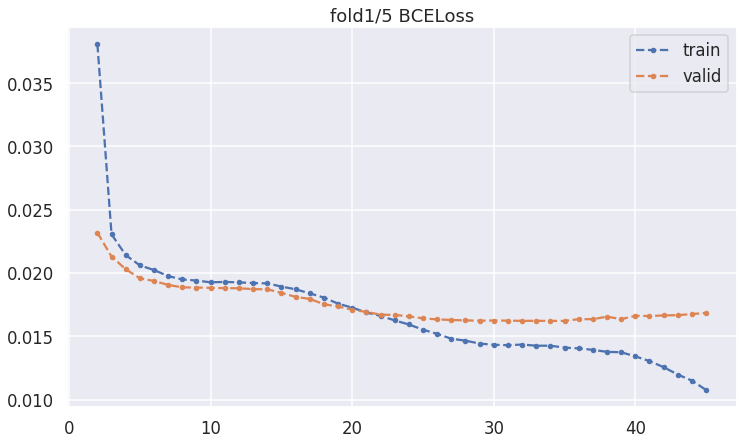



----------------------------------------------------------------------------------------------------
:: start fold 2/5 at Tue Oct 27 13:24:32 2020 ::
----------------------------------------------------------------------------------------------------
Epoch 01/45   loss: 0.39761   val_loss: 0.06539   mean_log_loss: 0.06309
Validation loss decreased (inf --> 0.065391).  Saving model ...
Epoch 02/45   loss: 0.03569   val_loss: 0.02332   mean_log_loss: 0.02329
Validation loss decreased (0.065391 --> 0.023317).  Saving model ...
Epoch 03/45   loss: 0.02311   val_loss: 0.02136   mean_log_loss: 0.02135
Validation loss decreased (0.023317 --> 0.021362).  Saving model ...
Epoch 04/45   loss: 0.02148   val_loss: 0.02012   mean_log_loss: 0.02010
Validation loss decreased (0.021362 --> 0.020119).  Saving model ...
Epoch 05/45   loss: 0.02060   val_loss: 0.01963   mean_log_loss: 0.01961
Validation loss decreased (0.020119 --> 0.019625).  Saving model ...
Epoch 06/45   loss: 0.02016   val_loss: 0.

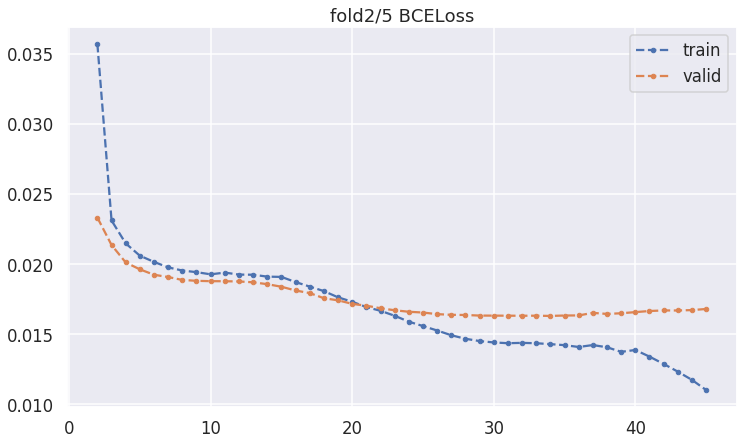



----------------------------------------------------------------------------------------------------
:: start fold 3/5 at Tue Oct 27 13:25:32 2020 ::
----------------------------------------------------------------------------------------------------
Epoch 01/45   loss: 0.39522   val_loss: 0.06315   mean_log_loss: 0.06319
Validation loss decreased (inf --> 0.063145).  Saving model ...
Epoch 02/45   loss: 0.03532   val_loss: 0.02254   mean_log_loss: 0.02258
Validation loss decreased (0.063145 --> 0.022542).  Saving model ...
Epoch 03/45   loss: 0.02281   val_loss: 0.02091   mean_log_loss: 0.02093
Validation loss decreased (0.022542 --> 0.020905).  Saving model ...
Epoch 04/45   loss: 0.02129   val_loss: 0.01991   mean_log_loss: 0.01994
Validation loss decreased (0.020905 --> 0.019909).  Saving model ...
Epoch 05/45   loss: 0.02053   val_loss: 0.01955   mean_log_loss: 0.01958
Validation loss decreased (0.019909 --> 0.019555).  Saving model ...
Epoch 06/45   loss: 0.01997   val_loss: 0.

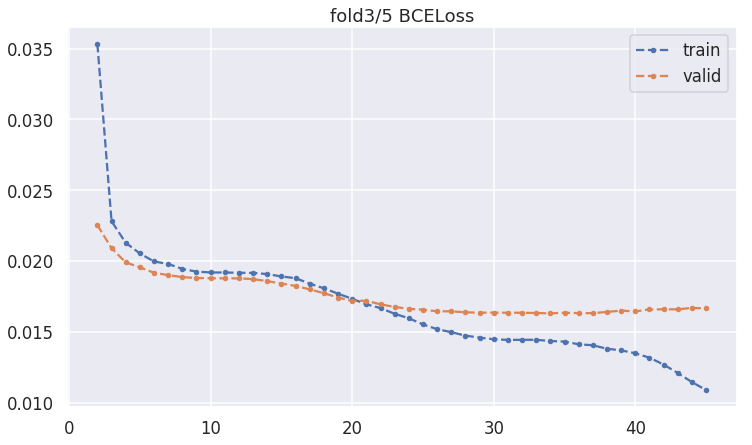



----------------------------------------------------------------------------------------------------
:: start fold 4/5 at Tue Oct 27 13:26:32 2020 ::
----------------------------------------------------------------------------------------------------
Epoch 01/45   loss: 0.41583   val_loss: 0.06666   mean_log_loss: 0.06482
Validation loss decreased (inf --> 0.066657).  Saving model ...
Epoch 02/45   loss: 0.03656   val_loss: 0.02341   mean_log_loss: 0.02347
Validation loss decreased (0.066657 --> 0.023413).  Saving model ...
Epoch 03/45   loss: 0.02280   val_loss: 0.02130   mean_log_loss: 0.02136
Validation loss decreased (0.023413 --> 0.021298).  Saving model ...
Epoch 04/45   loss: 0.02127   val_loss: 0.02053   mean_log_loss: 0.02059
Validation loss decreased (0.021298 --> 0.020531).  Saving model ...
Epoch 05/45   loss: 0.02068   val_loss: 0.02026   mean_log_loss: 0.02032
Validation loss decreased (0.020531 --> 0.020261).  Saving model ...
Epoch 06/45   loss: 0.02009   val_loss: 0.

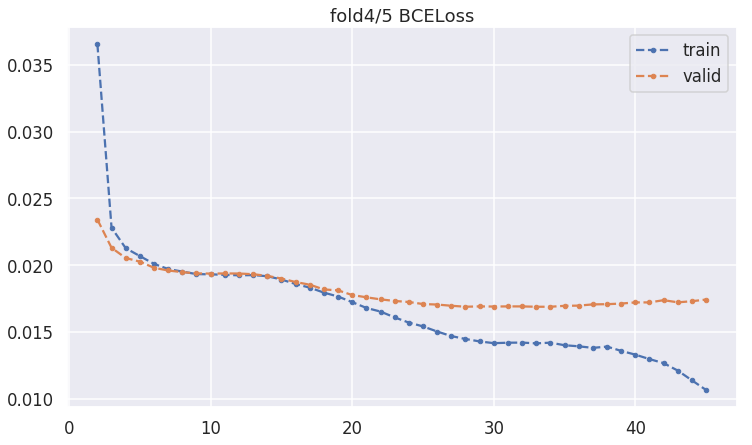



----------------------------------------------------------------------------------------------------
:: start fold 5/5 at Tue Oct 27 13:27:32 2020 ::
----------------------------------------------------------------------------------------------------
Epoch 01/45   loss: 0.43732   val_loss: 0.07501   mean_log_loss: 0.07223
Validation loss decreased (inf --> 0.075008).  Saving model ...
Epoch 02/45   loss: 0.03796   val_loss: 0.02331   mean_log_loss: 0.02332
Validation loss decreased (0.075008 --> 0.023314).  Saving model ...
Epoch 03/45   loss: 0.02300   val_loss: 0.02114   mean_log_loss: 0.02114
Validation loss decreased (0.023314 --> 0.021142).  Saving model ...
Epoch 04/45   loss: 0.02126   val_loss: 0.02025   mean_log_loss: 0.02025
Validation loss decreased (0.021142 --> 0.020253).  Saving model ...
Epoch 05/45   loss: 0.02065   val_loss: 0.01988   mean_log_loss: 0.01988
Validation loss decreased (0.020253 --> 0.019883).  Saving model ...
Epoch 06/45   loss: 0.02004   val_loss: 0.

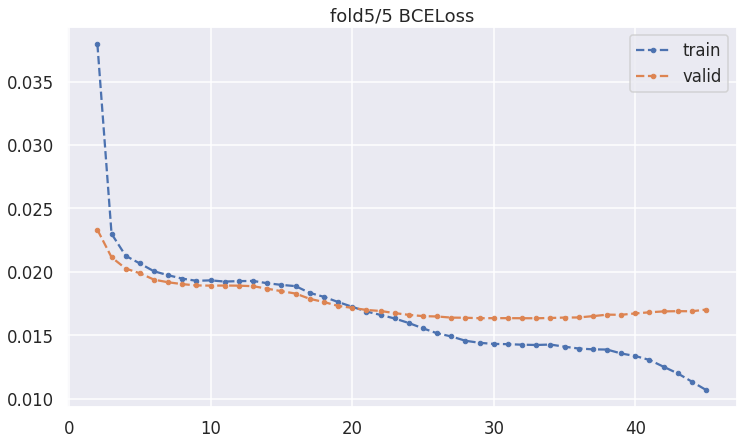



----------------------------------------------------------------------------------------------------
mean_log_loss(all fold): 0.016423 +- 0.000253
mean_log_loss(oof):      0.015136
----------------------------------------------------------------------------------------------------
CPU times: user 1min 44s, sys: 2min 53s, total: 4min 37s
Wall time: 5min 1s


In [46]:
%%time
mean_log_loss_list = []
# best_mean_log_loss = np.inf
oof = np.zeros_like(targets).astype(float)
for n, (idx_trn, idx_val) in enumerate(splitter.split(train, targets)):
    print('-'*100)
    print(f':: start fold {n+1}/{n_splits} at {time.ctime()} ::')
    print('-'*100)
    X_trn, X_val = train[idx_trn], train[idx_val]
    y_trn, y_val = targets[idx_trn], targets[idx_val]

    train_set = MoaDataset(X_trn, y_trn, mode='train')
    val_set = MoaDataset(X_val, y_val, mode='train')

    dataloaders = {
        'train': DataLoader(train_set, **settings['loader']['train']),
        'val': DataLoader(val_set, **settings['loader']['val']),
    }

    model = MoaModel(train.shape[1]).to(device)
    checkpoint_path = f'{SAVE_DIR}Fold{n+1}of{n_splits}.pt'
    early_stopping = EarlyStopping(patience=15, verbose=True, path=checkpoint_path)
    optimizer = optim.__getattribute__(settings['optimizer']['name'])(
        model.parameters(), **settings['optimizer']['params'])
    scheduler = optim.lr_scheduler.__getattribute__(settings['scheduler']['name'])(
        optimizer, **settings['scheduler']['params'])
    best_valid_loss = np.inf
    best_mean_log_loss = np.inf
    best_preds = 0
    val_losses = []
    trn_losses = []
    for epoch in range(n_epochs):
        train_loss =  train_model(model, device, dataloaders['train'], optimizer, scheduler, criterion)
        valid_loss, _mean_log_loss, preds = get_epoch_loss_score(model, device, dataloaders['val'], criterion)

        trn_losses.append(train_loss)
        val_losses.append(valid_loss)
        print(f"Epoch {str(epoch+1).zfill(2)}/{n_epochs }   loss: {train_loss:5.5f}   val_loss: {valid_loss:5.5f}   mean_log_loss: {_mean_log_loss:5.5f}")
        early_stopping(valid_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        if valid_loss < best_valid_loss: 
            best_valid_loss = valid_loss
            best_mean_log_loss = _mean_log_loss
            best_preds = preds

    # result
    print(f':: best mean_log_loss: {best_mean_log_loss:5.5f} ::')
    mean_log_loss_list.append(best_mean_log_loss)
    oof[idx_val, :] = best_preds
    # plot
    x = np.arange(1, len(trn_losses)+1)
    plt.figure(figsize=(12, 7))
    plt.plot(x[1:], trn_losses[1:], '--.', label='train')
    plt.plot(x[1:], val_losses[1:], '--.', label='valid')
    plt.title(f"fold{n+1}/{n_splits} {settings['loss']['name']}")
    plt.legend()
    plt.show()
    print('\n')
# result
mean_mean_log_loss = np.mean(mean_log_loss_list)
std_mean_log_loss = np.std(mean_log_loss_list)
new_oof = add_ctl_cp_oof(oof)
oof_score = mean_log_loss(train_targets.values, new_oof)
print('-'*100)
print(f"mean_log_loss(all fold): {mean_mean_log_loss:5.6f} +- {std_mean_log_loss:5.6f}")
print(f"mean_log_loss(oof):      {oof_score:5.6f}")
print('-'*100)

In [20]:
for thre in np.arange(0.01, 1, 0.1):
    new_oof_post_process = np.zeros_like(new_oof).astype(float) + 0.000001
    mask = new_oof > thre
    new_oof_post_process[mask] = 0.000009
    print(f'{thre:.2f}  {mean_log_loss(train_targets.values, new_oof_post_process):.6f}')

0.01  0.042933
0.11  0.045310
0.21  0.045498
0.31  0.045606
0.41  0.045681
0.51  0.045741
0.61  0.045804
0.71  0.045862
0.81  0.045938
0.91  0.046058


In [21]:
best_combo = []
best = np.inf
for low in progress_bar(np.logspace(-5, -0.2, 10)):
    for high in np.logspace(-0.2, 0, 10):
        new_oof_post_process = np.zeros_like(new_oof).astype(float) + low
        mask = new_oof > 0.8
        new_oof_post_process[mask] = high
        score = mean_log_loss(train_targets.values, new_oof_post_process)
        if score < best:
            best = score
            best_combo = [low, high]
        print(low, high)
        print(f'{score:.6f}')
        print('')
print(f'best combo: {best_combo}')
print(f'best_score: {best}')

1e-05 0.6309573444801932
0.031951

1e-05 0.6640827850634842
0.031918

1e-05 0.6989473207273484
0.031885

1e-05 0.7356422544596413
0.031853

1e-05 0.774263682681127
0.031821

1e-05 0.8149127469020743
0.031790

1e-05 0.8576958985908941
0.031761

1e-05 0.9027251779484575
0.031734

1e-05 0.9501185073181437
0.031713

1e-05 1.0
0.032359

3.414548873833601e-05 0.6309573444801932
0.028604

3.414548873833601e-05 0.6640827850634842
0.028571

3.414548873833601e-05 0.6989473207273484
0.028538

3.414548873833601e-05 0.7356422544596413
0.028506

3.414548873833601e-05 0.774263682681127
0.028474

3.414548873833601e-05 0.8149127469020743
0.028443

3.414548873833601e-05 0.8576958985908941
0.028414

3.414548873833601e-05 0.9027251779484575
0.028387

3.414548873833601e-05 0.9501185073181437
0.028366

3.414548873833601e-05 1.0
0.029012

0.00011659144011798311 0.6309573444801932
0.025316

0.00011659144011798311 0.6640827850634842
0.025282

0.00011659144011798311 0.6989473207273484
0.025250

0.00011659144011

In [22]:
print(log_loss([0, 0], [0, 1], labels=[0, 1]))
print(log_loss([0, 0], [0, 0.9], labels=[0, 1]))

17.26978799617044
1.1512925464970234
